In [ ]:
# Retrieves metadata for all Maryland GHCND weather stations via the NOAA CDO API.
import requests
import pandas as pd

TOKEN = "XUJeHeQHWOvQqKCQfdeJiAtyZQGVkezh"
headers = {"token": TOKEN, "Accept": "application/json"}

params = {"datasetid": "GHCND", "locationid": "FIPS:24", "limit": 1000}

resp = requests.get(
    "https://www.ncei.noaa.gov/cdo-web/api/v2/stations",
    headers=headers,
    params=params,
    timeout=(10, 60)
)
resp.raise_for_status()  
stations = pd.DataFrame(resp.json()["results"])[["id", "name", "latitude", "longitude"]]

station_ids = set(stations["id"].tolist())
print(f"Maryland stations fetched: {len(station_ids)}")


Maryland stations fetched: 752


In [4]:
# Downloads GHCN‐D daily files for 2010–2024, filters them for Maryland stations’ TMAX/TMIN/PRCP, and saves the long‑form CSV.
import gzip, io

plain_ids = {sid.split(":", 1)[1] for sid in station_ids}

years    = range(2010, 2025)
variables = {"TMAX", "TMIN", "PRCP"}
records  = []

for year in years:
    url = f"https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
    print(f"Processing {year}.csv.gz …")
    r = requests.get(url, timeout=(10,120))
    r.raise_for_status()
    with gzip.GzipFile(fileobj=io.BytesIO(r.content)) as gz:
        for raw in gz:
            line = raw.decode("utf-8").strip()
            parts = line.split(",")
            if len(parts) < 4:
                continue
            sid_file, date_str, dtype, val_str = parts[0], parts[1], parts[2], parts[3]
            if sid_file in plain_ids and dtype in variables:
                try:
                    v = float(val_str)
                except ValueError:
                    continue
                full_id = f"GHCND:{sid_file}"
                records.append((full_id, date_str, dtype, v))

# Build DataFrame and save
df_daily = pd.DataFrame(records, columns=["station","date","datatype","value"])
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily.to_csv("maryland_daily_weather_2010_2024.csv", index=False)
print("Saved daily data to 'maryland_daily_weather_2010_2024.csv'")

Processing 2010.csv.gz …
Processing 2011.csv.gz …
Processing 2012.csv.gz …
Processing 2013.csv.gz …
Processing 2014.csv.gz …
Processing 2015.csv.gz …
Processing 2016.csv.gz …
Processing 2017.csv.gz …
Processing 2018.csv.gz …
Processing 2019.csv.gz …
Processing 2020.csv.gz …
Processing 2021.csv.gz …
Processing 2022.csv.gz …
Processing 2023.csv.gz …
Processing 2024.csv.gz …
Saved daily data to 'maryland_daily_weather_2010_2024.csv'


In [ ]:
# Fetch Maryland GHCND station metadata & save to CSV

resp = requests.get(
    "https://www.ncei.noaa.gov/cdo-web/api/v2/stations",
    headers=headers,
    params={"datasetid": "GHCND", "locationid": "FIPS:24", "limit": 1000},
    timeout=(10, 60)
)
resp.raise_for_status()

stations = pd.DataFrame(resp.json()["results"])[["id", "latitude", "longitude"]]
stations_meta = stations.rename(columns={"id": "station"})
stations_meta.to_csv("maryland_stations_metadata.csv", index=False)
print("Saved 'maryland_stations_metadata.csv' with", len(stations_meta), "stations")


Saved 'maryland_stations_metadata.csv' with 752 stations


In [9]:
# Load daily CSV, pivot to wide, convert units, drop days missing TMAX/TMIN,


df_daily = pd.read_csv('maryland_daily_weather_2010_2024.csv', parse_dates=['date'])

df_wide = df_daily.pivot_table(
    index=['station','date'],
    columns='datatype',
    values='value',
    aggfunc='first'
).reset_index()


df_wide = df_wide.rename(columns={'PRCP':'PRECIP'})
for col in ['TMAX','TMIN','PRECIP']:
    if col in df_wide.columns:
        df_wide[col] = df_wide[col] / 10
    else:
        raise KeyError(f"Missing column {col} in df_wide!")

df_wide['AVG_daily'] = (df_wide['TMAX'] + df_wide['TMIN']) / 2
df_wide = df_wide.dropna(subset=['TMAX','TMIN'])

df_wide['YearMonth'] = df_wide['date'].dt.to_period('M').dt.to_timestamp()

monthly = df_wide.groupby(['station','YearMonth'], as_index=False).agg(
    AVG          = ('AVG_daily', 'mean'),
    Mean_TMAX    = ('TMAX',      'mean'),
    Mean_TMIN    = ('TMIN',      'mean'),
    Total_PRECIP = ('PRECIP',    'sum'),
)

monthly.to_csv('maryland_monthly_weather_2010_2024.csv', index=False)
print(" Saved monthly data to 'maryland_monthly_weather_2010_2024.csv'")

monthly.head()


 Saved monthly data to 'maryland_monthly_weather_2010_2024.csv'


,station,YearMonth,AVG,Mean_TMAX,Mean_TMIN,Total_PRECIP
0,GHCND:USC00180335,2010-01-01,2.112903,6.180645,-1.954839,61.2
1,GHCND:USC00180335,2010-02-01,2.153571,6.185714,-1.878571,128.5
2,GHCND:USC00180335,2010-03-01,8.337097,13.029032,3.645161,201.9
3,GHCND:USC00180335,2010-04-01,13.836667,19.446667,8.226667,27.7
4,GHCND:USC00180335,2010-05-01,18.766129,24.374194,13.158065,52.4


Epoch 20/100  loss 0.0116
Epoch 40/100  loss 0.0091
Epoch 60/100  loss 0.0087
Epoch 80/100  loss 0.0092
Epoch 100/100  loss 0.0093


/Users/zhangzhenlong/Desktop/biostat/geo/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/zhangzhenlong/Desktop/biostat/geo/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


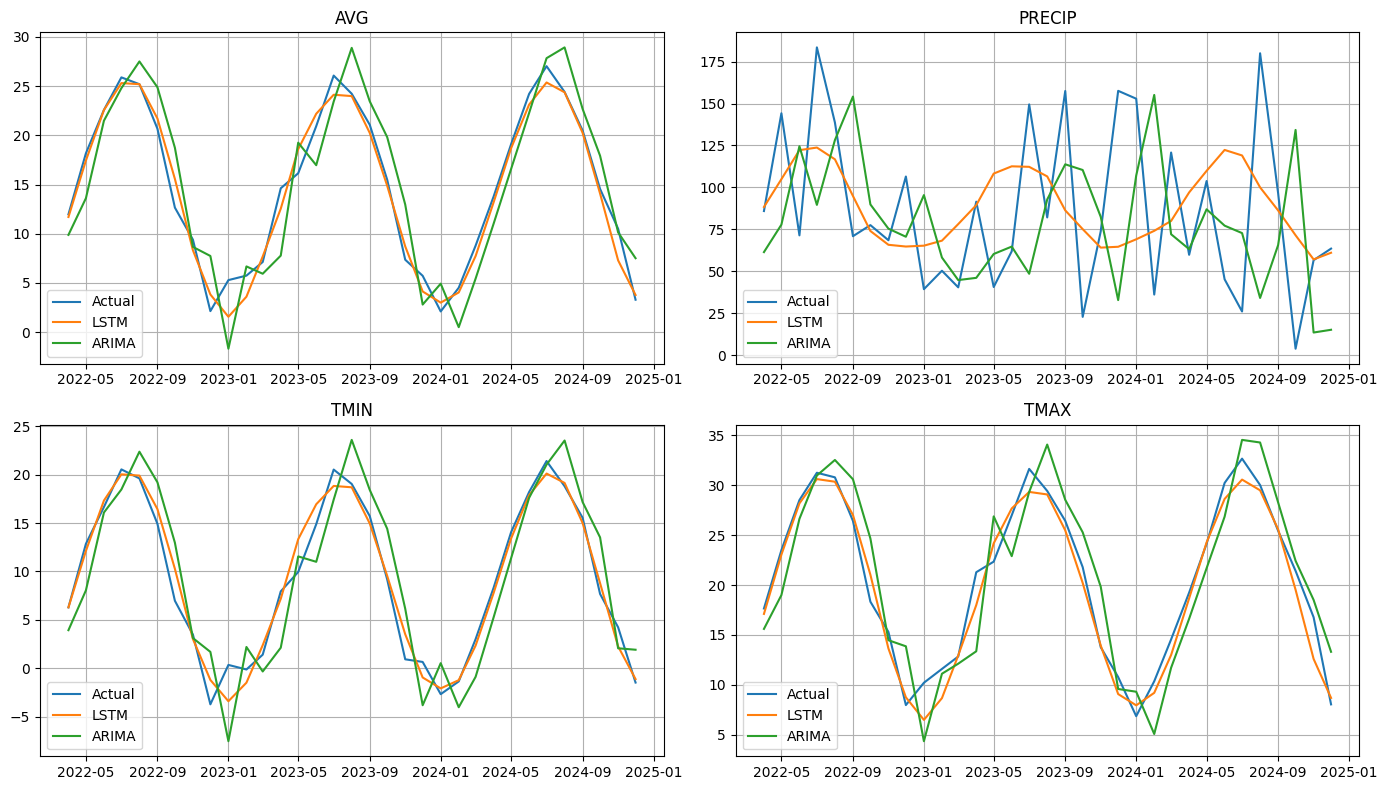

Station: GHCND:USC00180700
AVG: LSTM MAE=1.143, RMSE=1.477 | ARIMA MAE=3.221, RMSE=3.670
PRECIP: LSTM MAE=38.575, RMSE=47.951 | ARIMA MAE=48.822, RMSE=63.262
TMIN: LSTM MAE=1.156, RMSE=1.518 | ARIMA MAE=3.373, RMSE=3.826
TMAX: LSTM MAE=1.314, RMSE=1.698 | ARIMA MAE=3.246, RMSE=3.769


In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# ----- Load & preprocess -----
monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
station = "GHCND:USC00180700"
df = (monthly[monthly.station == station]
      .sort_values("YearMonth")
      .set_index("YearMonth")
      [["AVG", "Total_PRECIP", "Mean_TMIN", "Mean_TMAX"]]
      .rename(columns={"Total_PRECIP": "PRECIP"}))

# log1p on PRECIP
df["PRECIP"] = np.log1p(df["PRECIP"])

# scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
dates = df.index.to_numpy()

# ----- Create sequences -----
L = 16
X, Y = [], []
for i in range(len(scaled) - L):
    X.append(scaled[i:i + L])
    Y.append(scaled[i + L])
X = np.array(X)
Y = np.array(Y)

# train/test split
split = int(0.8 * len(X))
Xtr, Xte = X[:split], X[split:]
Ytr, Yte = Y[:split], Y[split:]
dates_te = dates[L:][split:]

# ----- LSTM -----
tr_ds = TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                      torch.tensor(Ytr, dtype=torch.float32))
tr_loader = DataLoader(tr_ds, batch_size=16, shuffle=True)
Xte_t = torch.tensor(Xte, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, in_dim=4, hid=64, out_dim=4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, batch_first=True)
        self.fc = nn.Linear(hid, out_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(100):
    model.train()
    tot = 0
    for xb, yb in tr_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100  loss {tot/len(tr_loader):.4f}")

model.eval()
with torch.no_grad():
    pred_s = model(Xte_t).numpy()

# inverse transform
raw_pred = scaler.inverse_transform(pred_s)
raw_pred[:, 1] = np.expm1(raw_pred[:, 1])
y_true = scaler.inverse_transform(Yte)
y_true[:, 1] = np.expm1(y_true[:, 1])

# ----- ARIMA -----
arima_preds = []
for i in range(4):
    series = df.iloc[:, i].values  # use same df with log1p
    pred_i = []
    for j in range(L, len(series)):
        train_series = series[j - L:j]
        try:
            model_arima = ARIMA(train_series, order=(1, 1, 0))
            fit = model_arima.fit()
            forecast = fit.forecast()[0]
        except:
            forecast = train_series[-1]
        pred_i.append(forecast)
    if i == 1:
        pred_i = np.expm1(pred_i)
    arima_preds.append(pred_i)

# align ARIMA with test set
arima_preds = [np.array(p)[-len(dates_te):] for p in arima_preds]

# ----- Plot -----
labels = ["AVG", "PRECIP", "TMIN", "TMAX"]
plt.figure(figsize=(14, 8))
for i, lbl in enumerate(labels):
    ax = plt.subplot(2, 2, i + 1)
    ax.plot(dates_te, y_true[:, i], label="Actual")
    ax.plot(dates_te, raw_pred[:, i], label="LSTM")
    ax.plot(dates_te, arima_preds[i], label="ARIMA")
    ax.set_title(lbl)
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

# ----- Evaluation -----
print(f"Station: {station}")
for i, lbl in enumerate(labels):
    mae_l = mean_absolute_error(y_true[:, i], raw_pred[:, i])
    rmse_l = np.sqrt(mean_squared_error(y_true[:, i], raw_pred[:, i]))
    mae_a = mean_absolute_error(y_true[:, i], arima_preds[i])
    rmse_a = np.sqrt(mean_squared_error(y_true[:, i], arima_preds[i]))
    print(f"{lbl}: LSTM MAE={mae_l:.3f}, RMSE={rmse_l:.3f} | ARIMA MAE={mae_a:.3f}, RMSE={rmse_a:.3f}")


[ConvLSTM] Epoch 0, Loss: 1.0440
[ConvLSTM] Epoch 50, Loss: 0.2774
[ConvLSTM] Test RMSE: 24.000, MAE: 10.965, R2: 0.652
[LSTM] Epoch 0, Loss: 1.0561
[LSTM] Epoch 50, Loss: 0.3315
[LSTM] Test RMSE: 24.148, MAE: 10.951, R2: 0.659


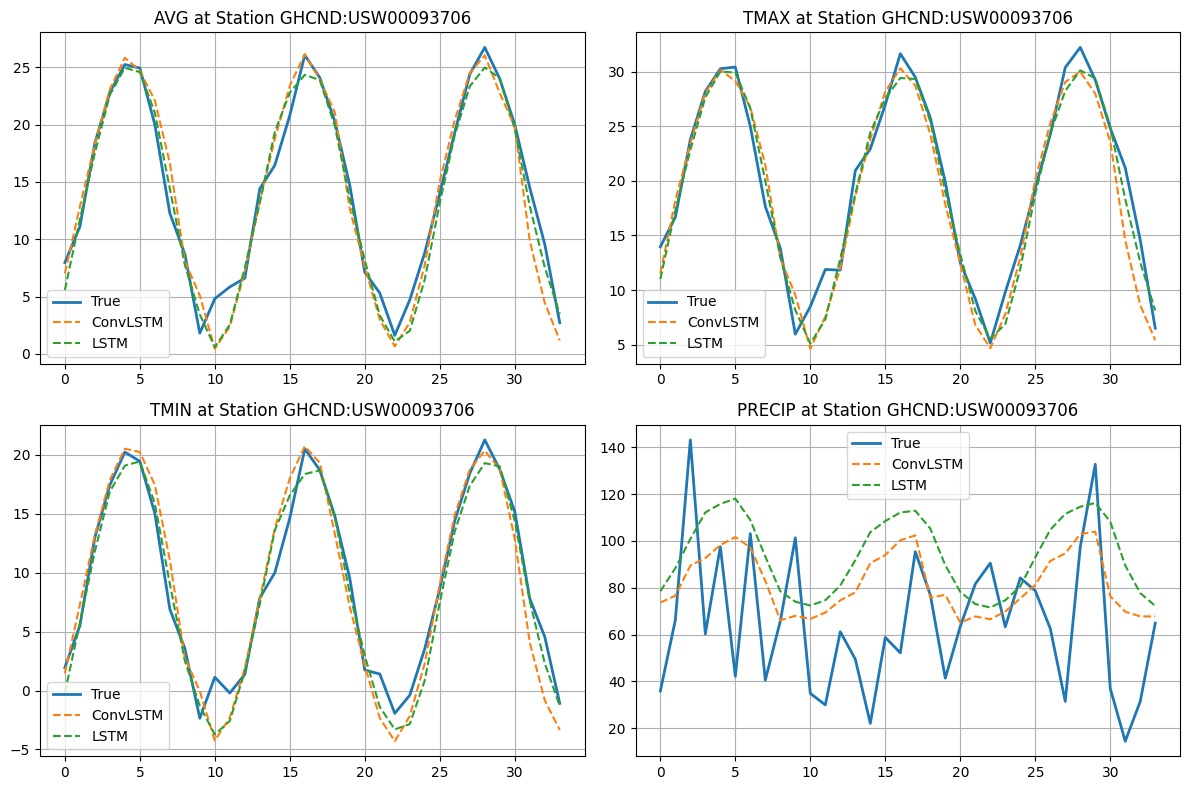

In [9]:

import torch, torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# ==== Step 1: Load and Normalize Data ====
monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
meta = pd.read_csv("maryland_stations_metadata.csv")

full_stations = [
    'GHCND:USC00180700','GHCND:USC00181790','GHCND:USC00182282',
    'GHCND:USC00182325','GHCND:USC00182336','GHCND:USC00182906',
    'GHCND:USC00183415','GHCND:USC00185934','GHCND:USW00013701',
    'GHCND:USW00013752','GHCND:USW00093706','GHCND:USW00093720',
    'GHCND:USW00093721','GHCND:USW00093786'
]

monthly = monthly[monthly.station.isin(full_stations)]
monthly = monthly.merge(meta, on="station")
features = ['AVG','Mean_TMAX','Mean_TMIN','Total_PRECIP']
monthly.sort_values(["YearMonth", "station"], inplace=True)

all_months = sorted(monthly.YearMonth.unique())
all_stations = full_stations

# [T, S, F]
data_tensor = np.zeros((len(all_months), len(all_stations), len(features)))
for i, m in enumerate(all_months):
    for j, s in enumerate(all_stations):
        row = monthly[(monthly.YearMonth == m) & (monthly.station == s)]
        data_tensor[i, j, :] = row[features].values[0]

flat = data_tensor.reshape(-1, data_tensor.shape[-1])
mean, std = flat.mean(axis=0), flat.std(axis=0)
data_tensor_norm = (data_tensor - mean) / std

# ==== Step 2: Make Samples ====
L = 12
X_list, Y_list = [], []
for i in range(L, len(all_months)):
    X_list.append(data_tensor_norm[i-L:i])     # [L, S, F]
    Y_list.append(data_tensor_norm[i, :, :])   # [S, 4] (multi-variable)

X = torch.tensor(np.stack(X_list), dtype=torch.float32)  # [B, L, S, F]
Y = torch.tensor(np.stack(Y_list), dtype=torch.float32)  # [B, S, 4]

# ==== Step 3: Train/Test Split ====
num_total = X.shape[0]
num_train = int(0.8 * num_total)
X_train, X_test = X[:num_train], X[num_train:]
Y_train, Y_test = Y[:num_train], Y[num_train:]

# ==== Step 4a: Enhanced ConvLSTM ====
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv = nn.Conv2d(input_dim + hidden_dim, hidden_dim * 4, kernel_size=3, padding=1)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class EnhancedConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super().__init__()
        self.cell1 = ConvLSTMCell(input_dim, hidden_dim)
        self.cell2 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.seq_len = seq_len
        self.out = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)

    def forward(self, x):
        B, T, S, F = x.shape
        W = int(np.ceil(np.sqrt(S)))
        H = int(np.ceil(S / W))
        x_grid = torch.zeros(B, T, F, H, W, device=x.device)
        x_reshaped = x.permute(0, 1, 3, 2).reshape(B, T, F, S)
        for idx in range(S):
            h_idx, w_idx = divmod(idx, W)
            x_grid[:, :, :, h_idx, w_idx] = x_reshaped[:, :, :, idx]
        h1 = torch.zeros(B, 64, H, W, device=x.device)
        c1 = torch.zeros_like(h1)
        h2 = torch.zeros(B, 64, H, W, device=x.device)
        c2 = torch.zeros_like(h2)
        for t in range(self.seq_len):
            h1, c1 = self.cell1(x_grid[:, t], h1, c1)
            h2, c2 = self.cell2(h1, h2, c2)
        out = self.out(h2).reshape(B, -1, 4)[:, :S, :]
        return out

# ==== Step 4b: Basic LSTM ====
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        B, L, S, F = x.shape
        x = x.permute(0,2,1,3).reshape(B*S, L, F)
        h, _ = self.lstm(x)
        out = self.out(h[:, -1]).reshape(B, S, -1)
        return out

# ==== Step 5: Train both models ====
models = {
    "ConvLSTM": EnhancedConvLSTM(4, 64, L, 4),
    "LSTM": BasicLSTM(4, 64, 4)
}

results = {}

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        pred = model(X_train)
        loss = nn.MSELoss()(pred, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"[{name}] Epoch {epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        pred_test = model(X_test).numpy() * std + mean
        true_test = Y_test.numpy() * std + mean
        results[name] = pred_test
        rmse = np.sqrt(np.mean((true_test - pred_test)**2))
        mae = np.mean(np.abs(true_test - pred_test))
        r2 = r2_score(true_test.reshape(-1, 4), pred_test.reshape(-1, 4))
        print(f"[{name}] Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# ==== Step 6: Plot 4 Subplots ====
i = np.random.randint(len(all_stations))
true_plot = Y_test.numpy() * std + mean
labels = ['AVG', 'TMAX', 'TMIN', 'PRECIP']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for v in range(4):
    ax = axes[v]
    ax.plot(true_plot[:, i, v], label="True", linewidth=2)
    for name in results:
        ax.plot(results[name][:, i, v], label=name, linestyle="--")
    ax.set_title(f"{labels[v]} at Station {all_stations[i]}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


[ConvLSTM] Epoch 0, Loss: 1.4790
[ConvLSTM] Epoch 50, Loss: 0.1700
[ConvLSTM] Test RMSE: 27.361, MAE: 12.075, R2: 0.564
[LSTM] Epoch 0, Loss: 1.0613
[LSTM] Epoch 50, Loss: 0.3289
[LSTM] Test RMSE: 23.924, MAE: 10.907, R2: 0.662


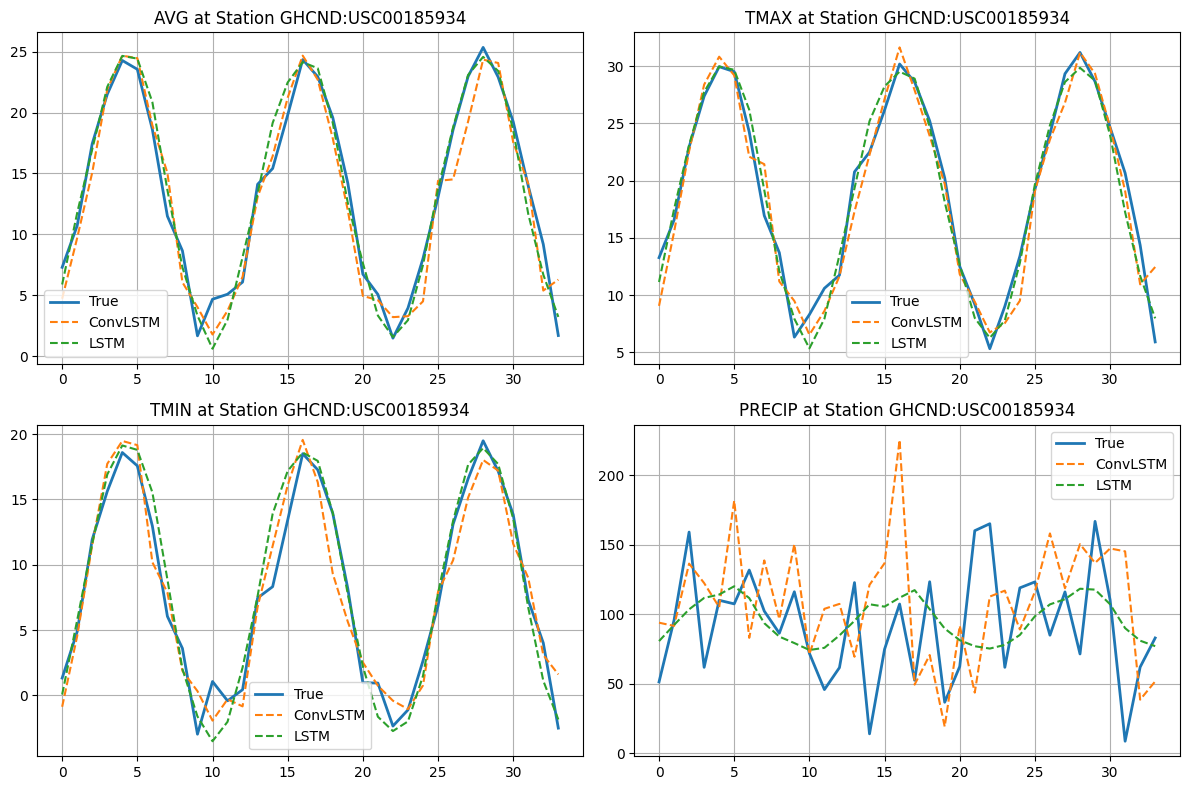

In [ ]:
# this is using only the stations that have the full conver
import torch, torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
meta = pd.read_csv("maryland_stations_metadata.csv")

full_stations = [
    'GHCND:USC00180700','GHCND:USC00181790','GHCND:USC00182282',
    'GHCND:USC00182325','GHCND:USC00182336','GHCND:USC00182906',
    'GHCND:USC00183415','GHCND:USC00185934','GHCND:USW00013701',
    'GHCND:USW00013752','GHCND:USW00093706','GHCND:USW00093720',
    'GHCND:USW00093721','GHCND:USW00093786'
]

monthly = monthly[monthly.station.isin(full_stations)]
monthly = monthly.merge(meta, on="station")
features = ['AVG','Mean_TMAX','Mean_TMIN','Total_PRECIP']
monthly.sort_values(["YearMonth", "station"], inplace=True)

all_months = sorted(monthly.YearMonth.unique())
all_stations = full_stations

data_tensor = np.zeros((len(all_months), len(all_stations), len(features)))
for i, m in enumerate(all_months):
    for j, s in enumerate(all_stations):
        row = monthly[(monthly.YearMonth == m) & (monthly.station == s)]
        data_tensor[i, j, :] = row[features].values[0]

flat = data_tensor.reshape(-1, data_tensor.shape[-1])
mean, std = flat.mean(axis=0), flat.std(axis=0)
data_tensor_norm = (data_tensor - mean) / std

L = 12
X_list, Y_list = [], []
for i in range(L, len(all_months)):
    X_list.append(data_tensor_norm[i-L:i])     
    Y_list.append(data_tensor_norm[i, :, :])   

X = torch.tensor(np.stack(X_list), dtype=torch.float32)
Y = torch.tensor(np.stack(Y_list), dtype=torch.float32)

#Train/Test Split 
num_total = X.shape[0]
num_train = int(0.8 * num_total)
X_train, X_test = X[:num_train], X[num_train:]
Y_train, Y_test = Y[:num_train], Y[num_train:]

# ConvLSTM 
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv = nn.Conv2d(input_dim + hidden_dim, hidden_dim * 4, 3, padding=1)
        self.norm = nn.LayerNorm([hidden_dim, 4, 4])

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return self.norm(h_next), c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.cell1 = ConvLSTMCell(input_dim, hidden_dim)
        self.cell2 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.cell3 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.fuse = nn.Sequential(
            nn.Conv2d(hidden_dim, 32, 1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, output_dim, 1)
        )

    def forward(self, x):
        B, T, S, F = x.shape
        W = int(np.ceil(np.sqrt(S)))
        H = int(np.ceil(S / W))
        x_grid = torch.zeros(B, T, F, H, W, device=x.device)
        x_reshaped = x.permute(0,1,3,2).reshape(B, T, F, S)
        for idx in range(S):
            h_idx, w_idx = divmod(idx, W)
            x_grid[:, :, :, h_idx, w_idx] = x_reshaped[:, :, :, idx]
        h1 = torch.zeros(B, self.hidden_dim, H, W, device=x.device)
        c1 = torch.zeros_like(h1)
        h2 = torch.zeros_like(h1)
        c2 = torch.zeros_like(h1)
        h3 = torch.zeros_like(h1)
        c3 = torch.zeros_like(h1)
        for t in range(self.seq_len):
            h1, c1 = self.cell1(x_grid[:, t], h1, c1)
            h2, c2 = self.cell2(h1, h2, c2)
            h3, c3 = self.cell3(h2, h3, c3)
        out = self.fuse(h3).reshape(B, -1, 4)[:, :S, :]
        return out

# Basic LSTM
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        B, L, S, F = x.shape
        x = x.permute(0,2,1,3).reshape(B*S, L, F)
        h, _ = self.lstm(x)
        out = self.out(h[:, -1]).reshape(B, S, -1)
        return out

models = {
    "ConvLSTM": ConvLSTM(4, 64, L, 4),
    "LSTM": BasicLSTM(4, 64, 4)
}

results = {}

for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        pred = model(X_train)
        loss = nn.MSELoss()(pred, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"[{name}] Epoch {epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        pred_test = model(X_test).numpy() * std + mean
        true_test = Y_test.numpy() * std + mean
        results[name] = pred_test
        rmse = np.sqrt(np.mean((true_test - pred_test)**2))
        mae = np.mean(np.abs(true_test - pred_test))
        r2 = r2_score(true_test.reshape(-1, 4), pred_test.reshape(-1, 4))
        print(f"[{name}] Test RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

i = np.random.randint(len(all_stations))
true_plot = Y_test.numpy() * std + mean
labels = ['AVG', 'TMAX', 'TMIN', 'PRECIP']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for v in range(4):
    ax = axes[v]
    ax.plot(true_plot[:, i, v], label="True", linewidth=2)
    for name in results:
        ax.plot(results[name][:, i, v], label=name, linestyle="--")
    ax.set_title(f"{labels[v]} at Station {all_stations[i]}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

[ConvLSTM] Epoch 0 Losses -> AVG: 1.3078, TMAX: 1.3565, TMIN: 1.4173, PRECIP: 1.3206
[ConvLSTM] Epoch 50 Losses -> AVG: 0.0378, TMAX: 0.0445, TMIN: 0.0445, PRECIP: 0.8166
[ConvLSTM] AVG RMSE: 2.39, MAE: 1.91, R2: 0.903
[ConvLSTM] TMAX RMSE: 2.61, MAE: 2.05, R2: 0.889
[ConvLSTM] TMIN RMSE: 2.53, MAE: 2.04, R2: 0.887
[ConvLSTM] PRECIP RMSE: 53.50, MAE: 41.44, R2: -0.550
[LSTM] Epoch 0 Losses -> AVG: 1.0497, TMAX: 0.9634, TMIN: 1.0316, PRECIP: 1.0986
[LSTM] Epoch 50 Losses -> AVG: 0.0877, TMAX: 0.1001, TMIN: 0.1007, PRECIP: 0.9936
[LSTM] AVG RMSE: 1.97, MAE: 1.57, R2: 0.932
[LSTM] TMAX RMSE: 2.15, MAE: 1.71, R2: 0.922
[LSTM] TMIN RMSE: 2.14, MAE: 1.70, R2: 0.918
[LSTM] PRECIP RMSE: 48.36, MAE: 38.98, R2: -0.282


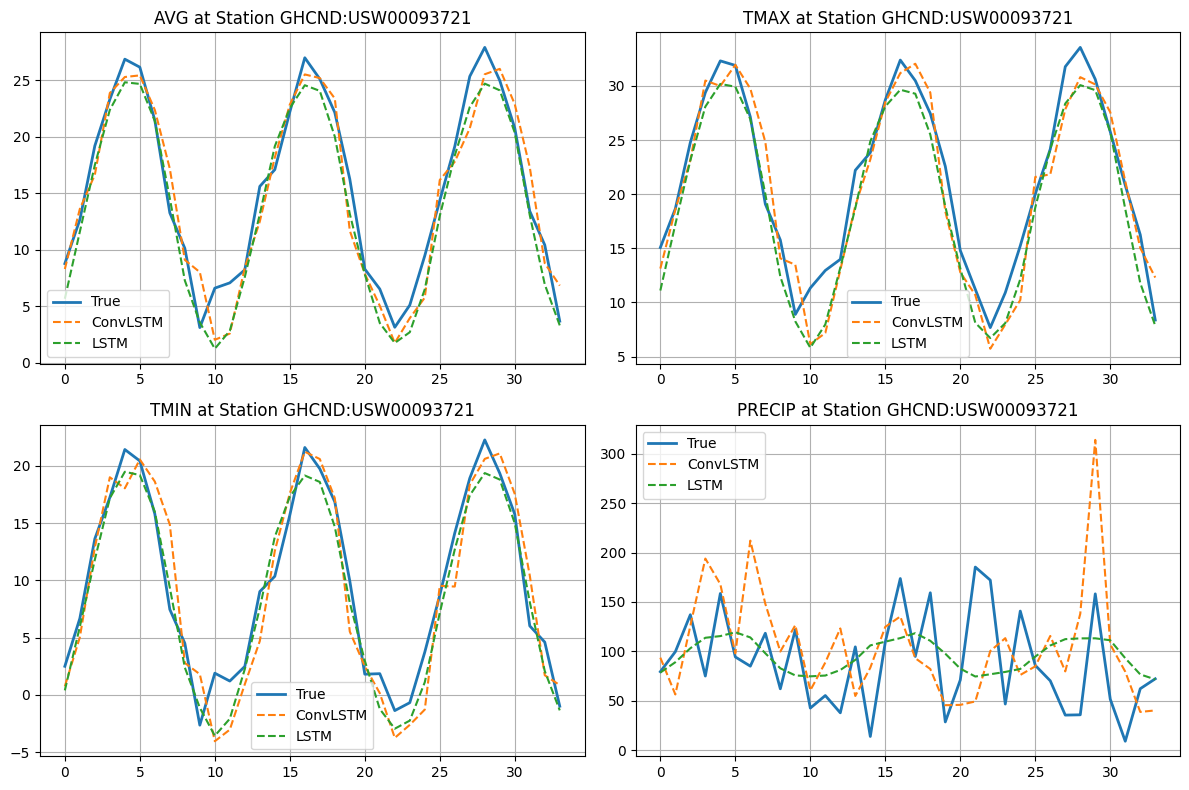

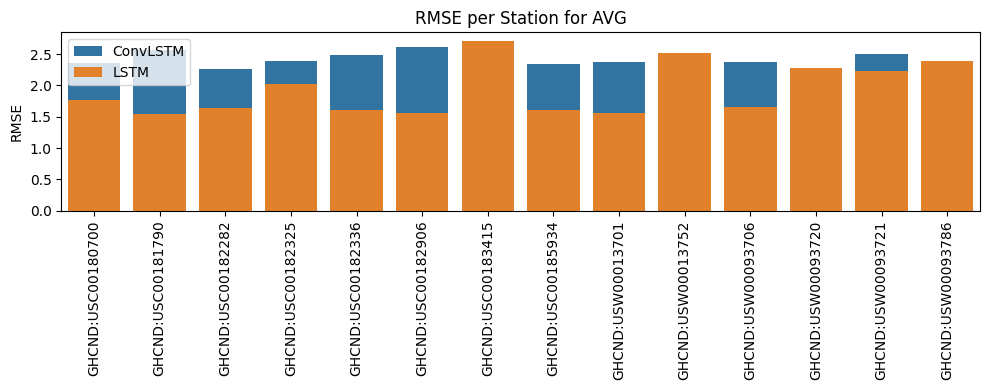

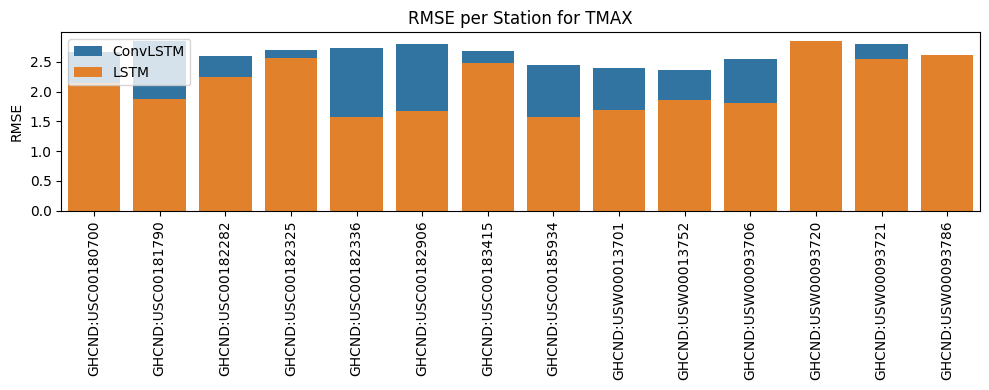

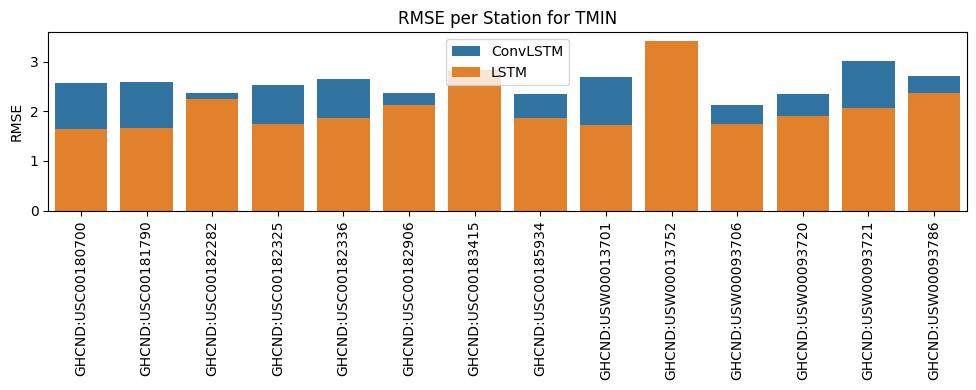

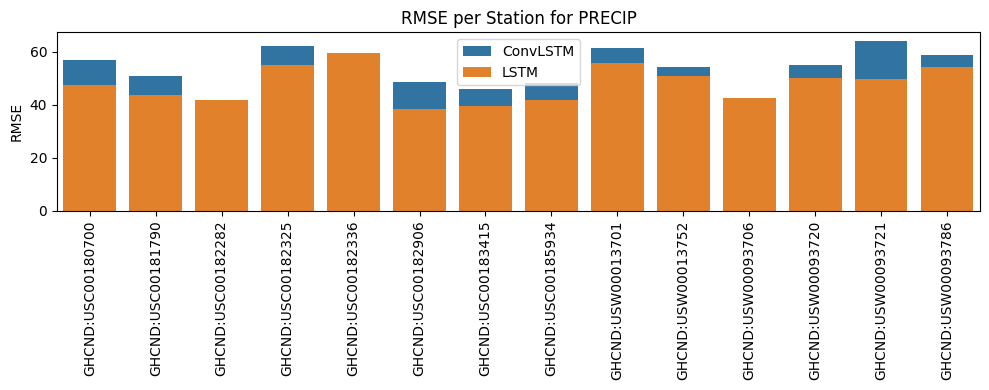

In [ ]:
# only use 14 stations

import torch, torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.interpolate import griddata

# ==== Step 1: Load and Normalize Data ====
monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
meta = pd.read_csv("maryland_stations_metadata.csv")

full_stations = [
    'GHCND:USC00180700','GHCND:USC00181790','GHCND:USC00182282',
    'GHCND:USC00182325','GHCND:USC00182336','GHCND:USC00182906',
    'GHCND:USC00183415','GHCND:USC00185934','GHCND:USW00013701',
    'GHCND:USW00013752','GHCND:USW00093706','GHCND:USW00093720',
    'GHCND:USW00093721','GHCND:USW00093786'
]

monthly = monthly[monthly.station.isin(full_stations)]
monthly = monthly.merge(meta, on="station")
features = ['AVG','Mean_TMAX','Mean_TMIN','Total_PRECIP']
monthly.sort_values(["YearMonth", "station"], inplace=True)

all_months = sorted(monthly.YearMonth.unique())
all_stations = full_stations

# ==== Step 2: Construct Geospatial Grid ====
coords = meta.set_index("station").loc[all_stations][["latitude","longitude"]].values
xlon = np.linspace(coords[:,1].min(), coords[:,1].max(), 4)
ylat = np.linspace(coords[:,0].min(), coords[:,0].max(), 4)
mesh_x, mesh_y = np.meshgrid(xlon, ylat)

station_indices = []
for lat, lon in coords:
    dist = (mesh_x - lon)**2 + (mesh_y - lat)**2
    idx = np.unravel_index(dist.argmin(), dist.shape)
    station_indices.append(idx)

# ==== Step 3: Create Tensor Samples ====
data_tensor = np.zeros((len(all_months), len(all_stations), len(features)))
for i, m in enumerate(all_months):
    for j, s in enumerate(all_stations):
        row = monthly[(monthly.YearMonth == m) & (monthly.station == s)]
        data_tensor[i, j, :] = row[features].values[0]

flat = data_tensor.reshape(-1, data_tensor.shape[-1])
mean, std = flat.mean(axis=0), flat.std(axis=0)
data_tensor_norm = (data_tensor - mean) / std

L = 12
X_list, Y_list = [], []
for i in range(L, len(all_months)):
    X_list.append(data_tensor_norm[i-L:i])
    Y_list.append(data_tensor_norm[i, :, :])

X = torch.tensor(np.stack(X_list), dtype=torch.float32)
Y = torch.tensor(np.stack(Y_list), dtype=torch.float32)

num_total = X.shape[0]
num_train = int(0.8 * num_total)
X_train, X_test = X[:num_train], X[num_train:]
Y_train, Y_test = Y[:num_train], Y[num_train:]

models = {
    "ConvLSTM": ConvLSTM(4, 64, L, 4),
    "LSTM": BasicLSTM(4, 64, 4)
}

results = {}
labels = ['AVG', 'TMAX', 'TMIN', 'PRECIP']

# ==== Step 6: Train and Evaluate ====
for name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(100):
        model.train()
        pred = model(X_train)
        losses = [(pred[:,:,v] - Y_train[:,:,v])**2 for v in range(4)]
        loss_vals = [torch.mean(l) for l in losses]
        total_loss = sum(loss_vals)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            loss_str = ', '.join([f"{labels[v]}: {loss_vals[v].item():.4f}" for v in range(4)])
            print(f"[{name}] Epoch {epoch} Losses -> {loss_str}")

    model.eval()
    with torch.no_grad():
        pred_test = model(X_test).numpy() * std + mean
        true_test = Y_test.numpy() * std + mean
        results[name] = pred_test
        for v in range(4):
            rmse = np.sqrt(np.mean((true_test[:,:,v] - pred_test[:,:,v])**2))
            mae  = np.mean(np.abs(true_test[:,:,v] - pred_test[:,:,v]))
            r2   = r2_score(true_test[:,:,v], pred_test[:,:,v])
            print(f"[{name}] {labels[v]} RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

# ==== Step 7: Plot Comparison ====
i = np.random.randint(len(all_stations))
true_plot = Y_test.numpy() * std + mean

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for v in range(4):
    ax = axes[v]
    ax.plot(true_plot[:, i, v], label="True", linewidth=2)
    for name in results:
        ax.plot(results[name][:, i, v], label=name, linestyle="--")
    ax.set_title(f"{labels[v]} at Station {all_stations[i]}")
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

# ==== Step 8: Heatmap of RMSE by Station ====
import seaborn as sns

for v in range(4):
    plt.figure(figsize=(10,4))
    for name, pred in results.items():
        rmse_per_station = np.sqrt(np.mean((pred[:,:,v] - true_plot[:,:,v])**2, axis=0))
        sns.barplot(x=all_stations, y=rmse_per_station, label=name)
    plt.xticks(rotation=90)
    plt.title(f"RMSE per Station for {labels[v]}")
    plt.ylabel("RMSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [47]:
import pandas as pd

df_daily = pd.read_csv("maryland_daily_weather_2010_2024.csv", parse_dates=["date"])
station_day_counts = df_daily.groupby("station")["date"].nunique()
max_days = station_day_counts.max()
full_length_stations = station_day_counts[station_day_counts == max_days]

print(f" Daily longest lenth: {max_days}")
print(f" numbers of stations reach the lenth: {len(full_length_stations)}")
print("example station:", full_length_stations.index.tolist()[:10])


 Daily longest lenth: 5479
 numbers of stations reach the lenth: 4
example station: ['GHCND:US1MDSM0001', 'GHCND:USC00185934', 'GHCND:USW00093706', 'GHCND:USW00093721']


In [43]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from math import ceil, sqrt

# ==== Step 1: Load Data ====
monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
meta = pd.read_csv("maryland_stations_metadata.csv")
features = ['AVG','Mean_TMAX','Mean_TMIN','Total_PRECIP']
monthly.sort_values(["YearMonth", "station"], inplace=True)
all_months = sorted(monthly.YearMonth.unique())
all_stations = sorted(monthly.station.unique())

# ==== Step 2: Grid Mapping ====
S = len(all_stations)
W = int(ceil(sqrt(S)))
H = int(ceil(S / W))
coords = meta.set_index("station").loc[all_stations][["latitude", "longitude"]].values
xlon = np.linspace(coords[:,1].min(), coords[:,1].max(), W)
ylat = np.linspace(coords[:,0].min(), coords[:,0].max(), H)
mesh_x, mesh_y = np.meshgrid(xlon, ylat)
station_indices = [np.unravel_index(np.argmin((mesh_x - lon)**2 + (mesh_y - lat)**2), mesh_x.shape)
                   for lat, lon in coords]

# ==== Step 3: Build Data Tensors ====
data_tensor = np.full((len(all_months), S, len(features)), np.nan)
for i, m in enumerate(all_months):
    for j, s in enumerate(all_stations):
        row = monthly[(monthly.YearMonth == m) & (monthly.station == s)]
        if not row.empty:
            data_tensor[i, j, :] = row[features].values[0]

flat = data_tensor.reshape(-1, data_tensor.shape[-1])
mean, std = np.nanmean(flat, axis=0), np.nanstd(flat, axis=0)
data_tensor_norm = (data_tensor - mean) / std
mask_tensor = ~np.isnan(data_tensor_norm)
data_tensor_norm[np.isnan(data_tensor_norm)] = 0

# ==== Step 4: Sequence Construction ====
L = 12
X, Y, M = [], [], []
for i in range(L, len(all_months)):
    X.append(data_tensor_norm[i-L:i])
    Y.append(data_tensor_norm[i])
    M.append(mask_tensor[i])
X = torch.tensor(np.stack(X), dtype=torch.float32)
Y = torch.tensor(np.stack(Y), dtype=torch.float32)
M = torch.tensor(np.stack(M), dtype=torch.float32)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_test = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]
M_train, M_test = M[:int(0.8*len(M))], M[int(0.8*len(M)):]

# ==== Step 5a: ConvLSTM ====
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv = nn.Conv2d(input_dim + hidden_dim, hidden_dim * 4, 3, padding=1)
        self.norm = nn.LayerNorm([hidden_dim, H, W])
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return self.drop(self.norm(h_next)), c_next

class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.cell1 = ConvLSTMCell(input_dim, hidden_dim)
        self.cell2 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.cell3 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.fuse = nn.Sequential(
            nn.Conv2d(hidden_dim, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Dropout2d(0.3), nn.Conv2d(64, output_dim, 1)
        )

    def forward(self, x):
        B, T, S_, F = x.shape
        x_grid = torch.zeros(B, T, F, H, W, device=x.device)
        x_reshaped = x.permute(0,1,3,2).reshape(B, T, F, S_)
        for idx, (hi, wi) in enumerate(station_indices):
            x_grid[:, :, :, hi, wi] = x_reshaped[:, :, :, idx]
        h1 = torch.zeros(B, self.hidden_dim, H, W, device=x.device)
        c1 = torch.zeros_like(h1)
        h2 = torch.zeros_like(h1)
        c2 = torch.zeros_like(h1)
        h3 = torch.zeros_like(h1)
        c3 = torch.zeros_like(h1)
        for t in range(self.seq_len):
            h1, c1 = self.cell1(x_grid[:, t], h1, c1)
            h2, c2 = self.cell2(h1, h2, c2)
            h3, c3 = self.cell3(h2, h3, c3)
        return self.fuse(h3).reshape(B, -1, 4)[:, :S_, :]

# ==== Step 5b: Basic LSTM ====
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        B, L, S, F = x.shape
        x = x.permute(0,2,1,3).reshape(B*S, L, F)
        h, _ = self.lstm(x)
        h = self.drop(h[:, -1])
        out = self.out(h)
        return out.reshape(B, S, -1)

# ==== Step 6: Train and Compare ====
def masked_mse(pred, target, mask):
    diff = (pred - target)**2
    return (diff * mask).sum() / mask.sum()

# ConvLSTM
model = ConvLSTMModel(4, 64, L, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(200):
    model.train()
    pred = model(X_train)
    loss = masked_mse(pred, Y_train, M_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"[ConvLSTM Epoch {epoch}] Loss: {loss.item():.4f}")

# Basic LSTM
lstm_model = BasicLSTM(4, 64, 4)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
for epoch in range(200):
    lstm_model.train()
    pred = lstm_model(X_train)
    loss = masked_mse(pred, Y_train, M_train)
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()
    if epoch % 25 == 0:
        print(f"[LSTM Epoch {epoch}] Loss: {loss.item():.4f}")

# ==== Step 7: Evaluation ====
labels = ['AVG', 'TMAX', 'TMIN', 'PRECIP']
with torch.no_grad():
    pred_cnn = model(X_test).numpy() * std + mean
    pred_lstm = lstm_model(X_test).numpy() * std + mean
    true = Y_test.numpy() * std + mean
    mask = M_test.numpy().astype(bool)

print("\n--- ConvLSTM Evaluation ---")
for v in range(4):
    t, p, m = true[:,:,v], pred_cnn[:,:,v], mask[:,:,v]
    print(f"{labels[v]} — RMSE: {np.sqrt(np.mean(((t-p)[m])**2)):.2f}, MAE: {np.mean(np.abs((t-p)[m])):.2f}, R2: {r2_score(t[m], p[m]):.3f}")

print("\n--- LSTM Evaluation ---")
for v in range(4):
    t, p, m = true[:,:,v], pred_lstm[:,:,v], mask[:,:,v]
    print(f"{labels[v]} — RMSE: {np.sqrt(np.mean(((t-p)[m])**2)):.2f}, MAE: {np.mean(np.abs((t-p)[m])):.2f}, R2: {r2_score(t[m], p[m]):.3f}")


[ConvLSTM Epoch 0] Loss: 1.6140
[ConvLSTM Epoch 25] Loss: 0.5448
[ConvLSTM Epoch 50] Loss: 0.4659
[ConvLSTM Epoch 75] Loss: 0.4092
[ConvLSTM Epoch 100] Loss: 0.3494
[ConvLSTM Epoch 125] Loss: 0.3141
[ConvLSTM Epoch 150] Loss: 0.2889
[ConvLSTM Epoch 175] Loss: 0.2672
[LSTM Epoch 0] Loss: 1.0357
[LSTM Epoch 25] Loss: 0.7862
[LSTM Epoch 50] Loss: 0.3624
[LSTM Epoch 75] Loss: 0.3250
[LSTM Epoch 100] Loss: 0.3108
[LSTM Epoch 125] Loss: 0.3008
[LSTM Epoch 150] Loss: 0.2936
[LSTM Epoch 175] Loss: 0.2886

--- ConvLSTM Evaluation ---
AVG — RMSE: 3.18, MAE: 2.53, R2: 0.835
TMAX — RMSE: 3.41, MAE: 2.74, R2: 0.813
TMIN — RMSE: 3.18, MAE: 2.55, R2: 0.837
PRECIP — RMSE: 53.51, MAE: 42.19, R2: -0.286

--- LSTM Evaluation ---
AVG — RMSE: 2.31, MAE: 1.80, R2: 0.913
TMAX — RMSE: 2.41, MAE: 1.89, R2: 0.907
TMIN — RMSE: 2.41, MAE: 1.89, R2: 0.906
PRECIP — RMSE: 48.35, MAE: 37.89, R2: -0.050


In [ ]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from math import ceil, sqrt

monthly = pd.read_csv("maryland_monthly_weather_2010_2024.csv", parse_dates=["YearMonth"])
meta = pd.read_csv("maryland_stations_metadata.csv")
features = ['AVG','Mean_TMAX','Mean_TMIN','Total_PRECIP']
monthly.sort_values(["YearMonth", "station"], inplace=True)
all_months = sorted(monthly.YearMonth.unique())
all_stations = sorted(monthly.station.unique())

S = len(all_stations)
W = int(ceil(sqrt(S)))
H = int(ceil(S / W))
coords = meta.set_index("station").loc[all_stations][["latitude", "longitude"]].values
xlon = np.linspace(coords[:,1].min(), coords[:,1].max(), W)
ylat = np.linspace(coords[:,0].min(), coords[:,0].max(), H)
mesh_x, mesh_y = np.meshgrid(xlon, ylat)
station_indices = [np.unravel_index(np.argmin((mesh_x - lon)**2 + (mesh_y - lat)**2), mesh_x.shape)
                   for lat, lon in coords]


data_tensor = np.full((len(all_months), S, len(features)), np.nan)
for i, m in enumerate(all_months):
    for j, s in enumerate(all_stations):
        row = monthly[(monthly.YearMonth == m) & (monthly.station == s)]
        if not row.empty:
            data_tensor[i, j, :] = row[features].values[0]

flat = data_tensor.reshape(-1, data_tensor.shape[-1])
mean, std = np.nanmean(flat, axis=0), np.nanstd(flat, axis=0)
data_tensor_norm = (data_tensor - mean) / std
mask_tensor = ~np.isnan(data_tensor_norm)
data_tensor_norm[np.isnan(data_tensor_norm)] = 0

L = 12
X, Y, M = [], [], []
for i in range(L, len(all_months)):
    X.append(data_tensor_norm[i-L:i])
    Y.append(data_tensor_norm[i])
    M.append(mask_tensor[i])
X = torch.tensor(np.stack(X), dtype=torch.float32)
Y = torch.tensor(np.stack(Y), dtype=torch.float32)
M = torch.tensor(np.stack(M), dtype=torch.float32)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_test = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]
M_train, M_test = M[:int(0.8*len(M))], M[int(0.8*len(M)):]

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv = nn.Conv2d(input_dim + hidden_dim, hidden_dim * 4, 3, padding=1)
        self.norm = nn.LayerNorm([hidden_dim, H, W])
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return self.drop(self.norm(h_next)), c_next

class ConvLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.cell1 = ConvLSTMCell(input_dim, hidden_dim)
        self.cell2 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.cell3 = ConvLSTMCell(hidden_dim, hidden_dim)
        self.fuse = nn.Sequential(
            nn.Conv2d(hidden_dim, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Dropout2d(0.3), nn.Conv2d(64, output_dim, 1)
        )

    def forward(self, x):
        B, T, S_, F = x.shape
        x_grid = torch.zeros(B, T, F, H, W, device=x.device)
        x_reshaped = x.permute(0,1,3,2).reshape(B, T, F, S_)
        for idx, (hi, wi) in enumerate(station_indices):
            x_grid[:, :, :, hi, wi] = x_reshaped[:, :, :, idx]
        h1 = torch.zeros(B, self.hidden_dim, H, W, device=x.device)
        c1 = torch.zeros_like(h1)
        h2 = torch.zeros_like(h1)
        c2 = torch.zeros_like(h1)
        h3 = torch.zeros_like(h1)
        c3 = torch.zeros_like(h1)
        for t in range(self.seq_len):
            h1, c1 = self.cell1(x_grid[:, t], h1, c1)
            h2, c2 = self.cell2(h1, h2, c2)
            h3, c3 = self.cell3(h2, h3, c3)
        return self.fuse(h3).reshape(B, -1, 4)[:, :S_, :]

#Basic LSTM 
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        B, L, S, F = x.shape
        x = x.permute(0,2,1,3).reshape(B*S, L, F)
        h, _ = self.lstm(x)
        h = self.drop(h[:, -1])
        out = self.out(h)
        return out.reshape(B, S, -1)

def masked_mse(pred, target, mask):
    diff = (pred - target)**2
    return (diff * mask).sum() / mask.sum()

# ConvLSTM
model = ConvLSTMModel(4, 64, L, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(200):
    model.train()
    pred = model(X_train)
    loss = masked_mse(pred, Y_train, M_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"[ConvLSTM Epoch {epoch}] Loss: {loss.item():.4f}")

# Basic LSTM
lstm_model = BasicLSTM(4, 64, 4)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
for epoch in range(200):
    lstm_model.train()
    pred = lstm_model(X_train)
    loss = masked_mse(pred, Y_train, M_train)
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()
    if epoch % 25 == 0:
        print(f"[LSTM Epoch {epoch}] Loss: {loss.item():.4f}")

labels = ['AVG', 'TMAX', 'TMIN', 'PRECIP']
with torch.no_grad():
    pred_cnn = model(X_test).numpy() * std + mean
    pred_lstm = lstm_model(X_test).numpy() * std + mean
    true = Y_test.numpy() * std + mean
    mask = M_test.numpy().astype(bool)

print("\n--- ConvLSTM Evaluation ---")
for v in range(4):
    t, p, m = true[:,:,v], pred_cnn[:,:,v], mask[:,:,v]
    print(f"{labels[v]} — RMSE: {np.sqrt(np.mean(((t-p)[m])**2)):.2f}, MAE: {np.mean(np.abs((t-p)[m])):.2f}, R2: {r2_score(t[m], p[m]):.3f}")

print("\n--- LSTM Evaluation ---")
for v in range(4):
    t, p, m = true[:,:,v], pred_lstm[:,:,v], mask[:,:,v]
    print(f"{labels[v]} — RMSE: {np.sqrt(np.mean(((t-p)[m])**2)):.2f}, MAE: {np.mean(np.abs((t-p)[m])):.2f}, R2: {r2_score(t[m], p[m]):.3f}")
conv_hidden_list = []
model.eval()
with torch.no_grad():
    B, T, S_, F = X_test.shape
    x_grid = torch.zeros(B, T, F, H, W)
    x_reshaped = X_test.permute(0,1,3,2).reshape(B, T, F, S_)
    for idx, (hi, wi) in enumerate(station_indices):
        x_grid[:, :, :, hi, wi] = x_reshaped[:, :, :, idx]

    h1 = torch.zeros(B, model.hidden_dim, H, W)
    c1 = torch.zeros_like(h1)
    h2 = torch.zeros_like(h1)
    c2 = torch.zeros_like(h1)
    h3 = torch.zeros_like(h1)
    c3 = torch.zeros_like(h1)
    h3_seq = []

    for t in range(model.seq_len):
        h1, c1 = model.cell1(x_grid[:, t], h1, c1)
        h2, c2 = model.cell2(h1, h2, c2)
        h3, c3 = model.cell3(h2, h3, c3)
        h3_seq.append(h3.clone())  
    h3_seq = torch.stack(h3_seq) 
    h3_station = torch.zeros(model.seq_len, B, S_, model.hidden_dim)

    for idx, (hi, wi) in enumerate(station_indices):
        h3_station[:, :, idx, :] = h3_seq[:, :, :, hi, wi].permute(0,1,2)

    conv_hidden_states = h3_station.numpy()  
lstm_model.eval()
with torch.no_grad():
    B, L, S, F = X_test.shape
    x = X_test.permute(0, 2, 1, 3).reshape(B*S, L, F)
    h, _ = lstm_model.lstm(x)
    h_full = h.detach().numpy().reshape(B, S, L, -1)  
    lstm_hidden_states = h_full.transpose(2, 0, 1, 3)  


[ConvLSTM Epoch 0] Loss: 1.4056
[ConvLSTM Epoch 25] Loss: 0.5124
[ConvLSTM Epoch 50] Loss: 0.4251
[ConvLSTM Epoch 75] Loss: 0.3674
[ConvLSTM Epoch 100] Loss: 0.3375
[ConvLSTM Epoch 125] Loss: 0.2954
[ConvLSTM Epoch 150] Loss: 0.2589
[ConvLSTM Epoch 175] Loss: 0.2250
[LSTM Epoch 0] Loss: 1.0187
[LSTM Epoch 25] Loss: 0.7535
[LSTM Epoch 50] Loss: 0.3624
[LSTM Epoch 75] Loss: 0.3246
[LSTM Epoch 100] Loss: 0.3103
[LSTM Epoch 125] Loss: 0.3008
[LSTM Epoch 150] Loss: 0.2937
[LSTM Epoch 175] Loss: 0.2861

--- ConvLSTM Evaluation ---
AVG — RMSE: 3.54, MAE: 2.87, R2: 0.794
TMAX — RMSE: 3.78, MAE: 3.10, R2: 0.771
TMIN — RMSE: 3.37, MAE: 2.72, R2: 0.816
PRECIP — RMSE: 53.67, MAE: 43.13, R2: -0.294

--- LSTM Evaluation ---
AVG — RMSE: 2.28, MAE: 1.77, R2: 0.915
TMAX — RMSE: 2.44, MAE: 1.92, R2: 0.904
TMIN — RMSE: 2.39, MAE: 1.86, R2: 0.908
PRECIP — RMSE: 48.49, MAE: 38.11, R2: -0.057


In [ ]:
# creating gifs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.animation as animation
from sklearn.metrics.pairwise import cosine_similarity


lstm_hidden = lstm_hidden_states.transpose(1, 2, 0, 3).reshape(-1, lstm_hidden_states.shape[2], lstm_hidden_states.shape[3])
conv_hidden = conv_hidden_states.transpose(1, 2, 0, 3).reshape(-1, conv_hidden_states.shape[2], conv_hidden_states.shape[3])


all_stations = sorted(pd.unique(monthly["station"])) 
meta_used = meta.set_index("station").loc[all_stations]
coords = meta_used[["latitude", "longitude"]].values  
def create_heatmap_gif(hidden, coords, model_name):
    T, S, D = hidden.shape
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.get_cmap("Blues")
    norm = plt.Normalize(hidden.min(), hidden.max())

    
    scat = ax.scatter(coords[:, 1], coords[:, 0], c=hidden[0, :, 0], 
                      cmap=cmap, s=60, norm=norm, alpha=1.0)
    plt.colorbar(scat, ax=ax, label="Hidden Value")
    ax.set_title(f"{model_name} Hidden State Dynamics")
    ax.set_xlim(coords[:, 1].min() - 0.1, coords[:, 1].max() + 0.1)
    ax.set_ylim(coords[:, 0].min() - 0.1, coords[:, 0].max() + 0.1)

    def update(t):
        h_t = hidden[t]  
        sim = cosine_similarity(h_t)  
        sim_mean = sim.mean(axis=1)  

        color = hidden[t, :, 0]
        alpha = (sim_mean - sim_mean.min()) / (sim_mean.max() - sim_mean.min() + 1e-6)
        scat.set_offsets(np.stack([coords[:, 1], coords[:, 0]], axis=1))
        scat.set_array(color)
        scat.set_alpha(alpha)
        ax.set_title(f"{model_name} Month {t}")
        return scat,

    ani = animation.FuncAnimation(fig, update, frames=T, interval=300)
    ani.save(f"{model_name}_cluster_opacity.gif", writer="pillow")
    plt.close()


create_heatmap_gif(lstm_hidden, coords, "LSTM")
create_heatmap_gif(conv_hidden, coords, "ConvLSTM")


In [ ]:
# moran's i to see if CNN lstm can capture spaticial differences better than lstm

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

lstm_hidden = lstm_hidden_states.transpose(1, 2, 0, 3).reshape(-1, lstm_hidden_states.shape[2], lstm_hidden_states.shape[3])
conv_hidden = conv_hidden_states.transpose(1, 2, 0, 3).reshape(-1, conv_hidden_states.shape[2], conv_hidden_states.shape[3])

meta_used = meta.set_index("station").loc[all_stations]
coords = meta_used[["latitude", "longitude"]].values

def compute_morans_I(x, coords, k=8):
    x = np.asarray(x).flatten()
    x_bar = x.mean()
    N = len(x)
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(coords)
    _, indices = nbrs.kneighbors(coords)
    W = np.zeros((N, N))
    for i in range(N):
        for j in indices[i][1:]:  
            W[i, j] = 1
    W_sum = W.sum()
    num = sum(W[i, j] * (x[i] - x_bar) * (x[j] - x_bar) for i in range(N) for j in range(N))
    den = np.sum((x - x_bar)**2)
    return N / W_sum * num / den

def compute_morans_series(hidden, coords, model_name):
    T = hidden.shape[0]
    morans = []
    for t in range(T):
        h = hidden[t]  
        pc1 = PCA(n_components=1).fit_transform(h).flatten()
        I = compute_morans_I(pc1, coords)
        morans.append(I)
    pd.Series(morans).to_csv(f"{model_name}_moransI.csv", index=False)
    return morans

lstm_morans = compute_morans_series(lstm_hidden, coords, "LSTM")
conv_morans = compute_morans_series(conv_hidden, coords, "ConvLSTM")



# Summary Statistics 
lstm_mean, lstm_std = np.mean(lstm_morans), np.std(lstm_morans)
conv_mean, conv_std = np.mean(conv_morans), np.std(conv_morans)

print(f"LSTM Moran's I:     mean = {lstm_mean:.4f}, std = {lstm_std:.4f}")
print(f"ConvLSTM Moran's I: mean = {conv_mean:.4f}, std = {conv_std:.4f}")

# Permutation Test 
observed_diff = conv_mean - lstm_mean
combined = np.concatenate([conv_morans, lstm_morans])
n = len(conv_morans)
num_permutations = 10000
diffs = []

for _ in range(num_permutations):
    np.random.shuffle(combined)
    d1, d2 = combined[:n], combined[n:]
    diffs.append(np.mean(d1) - np.mean(d2))

p_val_perm = (np.abs(diffs) >= np.abs(observed_diff)).mean()
print(f"\nPermutation test: observed diff = {observed_diff:.4f}, p = {p_val_perm:.4f}")
if p_val_perm < 0.05:
    print("→ Significant difference based on permutation test.")
else:
    print("→ No significant difference based on permutation test.")







LSTM Moran's I:     mean = -0.0209, std = 0.0403
ConvLSTM Moran's I: mean = -0.0163, std = 0.0539

Permutation test: observed diff = 0.0046, p = 0.1595
→ No significant difference based on permutation test.
